In [85]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp
import tqdm
import importlib
import sklearn
import pandas as pd
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [491]:
class Net(nn.Module):

    def __init__(self,input_size):
        super(Net, self).__init__()
        #input_size should be the length of the features vector, specified at the begining 
        self.fc1 = nn.Linear(input_size, input_size*4)
        self.fc2 = nn.Linear(input_size*4, input_size*4)
        self.fc3 = nn.Linear(input_size*4, input_size*4)
        self.fc4 = nn.Linear(input_size*4, input_size*4)
        self.fc5 = nn.Linear(input_size*4, 2)

    def forward(self, x):
        m = nn.LeakyReLU(0.5)
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
        x = m(self.fc4(x))
        #x = m(x)
        x = torch.softmax(x,dim=1)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [529]:
dataframe = pd.read_csv('/Users/linusbleistein/Desktop/grouped_data_final.csv')
print(dataframe.shape)

dataframe = dataframe.fillna(0)
print(dataframe.shape)
print(dataframe.head())

(757152, 158)
(757152, 158)
                                      address         1         2         3  \
0  0x0000000000000000000000000000000000000000  0.000413  0.000465  0.000228   
1  0x0000000000000000000000000000000000000001 -0.002620  0.003061  0.001861   
2  0x00000000000000000000000000000000000000dd -0.001442  0.000543  0.002878   
3  0x000000000000000000000000000000000000dead -0.000639 -0.000234 -0.001112   
4  0x0000000000000000000000000000000345345345 -0.000331  0.001366  0.001267   

          4         5         6         7         8         9  ...       148  \
0 -0.000245 -0.000531 -0.000771 -0.000661 -0.000468 -0.001271  ...  0.000530   
1  0.002846 -0.000234 -0.000055  0.001062 -0.001608 -0.001876  ...  0.000063   
2  0.001355 -0.001116  0.001555 -0.002369  0.002881  0.002679  ... -0.001709   
3 -0.001515 -0.000941  0.002249  0.000655 -0.000486  0.000368  ... -0.000244   
4  0.002618 -0.000867  0.001465 -0.000679  0.002000 -0.001403  ...  0.000945   

        149     

In [530]:
dataframe=dataframe.drop(['address'],axis=1)

In [531]:
col_list = list(dataframe)
col_list[-5], col_list[-1] = col_list[-1], col_list[-5]
dataframe.columns = col_list

In [532]:
print(col_list)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', 'value', 'unix_block_timestamp', 'lifetime', 'tfrequency'

In [533]:
dataframe = dataframe.to_numpy()

In [534]:
dataframe = torch.Tensor(dataframe)

In [535]:
dataset = torch.utils.data.TensorDataset(dataframe[:,0:-1],dataframe[:,-1])

In [544]:
batch_size=64
dataset_size = len(dataset)
indices = list(range(dataset_size))
validation_split = 0.7
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)



In [550]:
net=Net(input_size=156)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

losslist =[]

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in tqdm.tqdm(enumerate(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losslist.append(loss.item())
        if i % 100 == 99:    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %
                  #(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

3550it [00:30, 117.16it/s]
3550it [00:31, 113.23it/s]
3550it [00:35, 100.42it/s]
3550it [00:34, 103.23it/s]
3550it [00:47, 75.36it/s]
3550it [00:32, 108.56it/s]
3550it [00:29, 121.29it/s]
3550it [00:28, 123.61it/s]
3550it [00:26, 131.66it/s]
3550it [00:27, 126.84it/s]

Finished Training


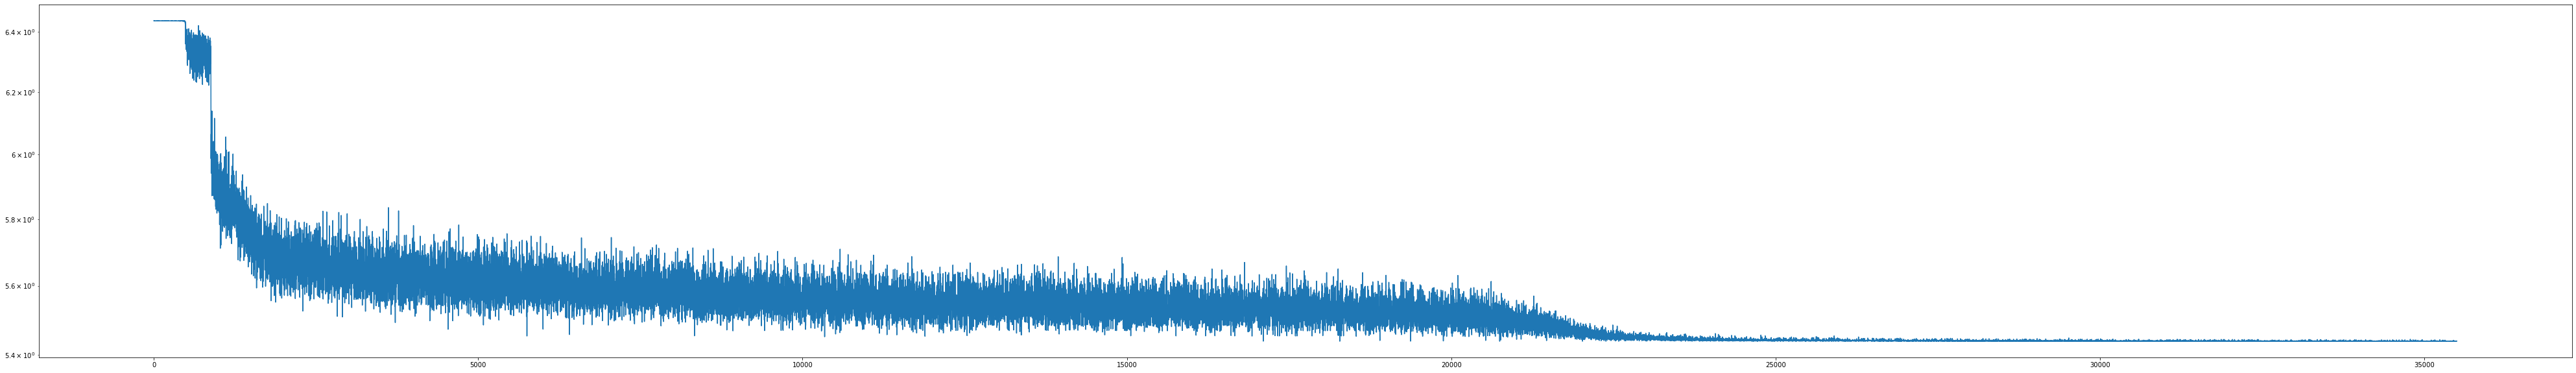

In [565]:
f,ax=plt.subplots(figsize=(70,10))
plt.plot(losslist)
plt.yscale('log')
plt.savefig('loss.pdf')
plt.show()

In [552]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test dataset: %d %%' % (
    100 * correct / total))
print(total)

Accuracy of the network on the test dataset: 80 %
530006


In [554]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix()

In [555]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

test = get_all_preds(net,validation_loader)
preds = torch.max(test,axis=1)

KeyboardInterrupt: 

In [561]:
print(preds[1])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,